In [23]:
import os
import numpy as np
from astropy.table import Table
import requests
import time
from io import StringIO
import wget
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from glob import glob
from astropy.visualization import simple_norm
from astropy.stats import SigmaClip
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources,SourceFinder,SourceCatalog
from photutils.background import Background2D, MADStdBackgroundRMS
from photutils.utils import circular_footprint, calc_total_error
 
# os.mkdir = 'ps1_dir'
ps1filename = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
fitscut = "https://ps1images.stsci.edu/cgi-bin/fitscut.cgi"
 
# modified from https://outerspace.stsci.edu/display/PANSTARRS/PS1+Image+Cutout+Service
def getimages(tra, tdec, size=1024, filters="grizy", format="fits", imagetypes="stack"):
    """Query ps1filenames.py service for multiple positions to get a list of images
    This adds a url column to the table to retrieve the cutout.

    tra, tdec = list of positions in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    format = data format (options are "fits", "jpg", or "png")
    imagetypes = list of any of the acceptable image types.  Default is stack;
        other common choices include warp (single-epoch images), stack.wt (weight image),
        stack.mask, stack.exp (exposure time), stack.num (number of exposures),
        warp.wt, and warp.mask.  This parameter can be a list of strings or a
        comma-separated string.
 
    Returns an astropy table with the results
    """

    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    # if imagetypes is a list, convert to a comma-separated string
    if not isinstance(imagetypes,str):
        imagetypes = ",".join(imagetypes)
    # put the positions in an in-memory file object
    cbuf = StringIO()
    cbuf.write('\n'.join(["{} {}".format(ra, dec) for (ra, dec) in zip(tra,tdec)]))
    cbuf.seek(0)
    # use requests.post to pass in positions as a file
    r = requests.post(ps1filename, data=dict(filters=filters, type=imagetypes),
        files=dict(file=cbuf))
    r.raise_for_status()
    tab = Table.read(r.text, format="ascii")
 
    tab["url"] = ["{}?red={}&format={}&x={}&y={}&size={}&wcs=1&imagename={}".format(fitscut,
                                                                                    filename,
                                                                                    format,
                                                                                    ra,dec,size,
                                                                                    'cutout_'+shortname) 
                  for (filename,ra,dec,shortname) in zip(tab["filename"],tab["ra"],tab["dec"],tab['shortname'])]
    return tab

In [24]:
t0 = time.time()
 
# create a test set of image positions
tra = [161.77716667]   
tdec = [0.01102778]

# get the PS1 info for those positions
table = getimages(tra,tdec,filters="r")

# download the cutout to your directory
if not os.path.exists('./ps1_dir'):
    os.mkdir('./ps1_dir')
wget.download(table['url'][0],out='ps1_dir')

'ps1_dir/cutout_rings.v3.skycell.1362.000.stk.r.unconv (1).fits'

In [25]:
# estimate background to get background subtracted data and background error in counts

def background_subtracted(data):
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    threshold = detect_threshold(data, nsigma=3, sigma_clip=sigma_clip)
    segment_img = detect_sources(data, threshold, npixels=4)
    footprint = circular_footprint(radius=3)
    mask = segment_img.make_source_mask(footprint=footprint)
    xsize = round(data.shape[1]/100)
    ysize = round(data.shape[0]/100)
    bkg = Background2D(data, (ysize,xsize), filter_size=(3, 3),mask=mask,
                       bkgrms_estimator = MADStdBackgroundRMS(sigma_clip))
    sub_data = data-bkg.background
    return sub_data, bkg

In [26]:
## load the data 
sn_image = glob('ps1_dir/*.fits')[0]
sn = fits.open(sn_image)
sn_data, sn_bkg = background_subtracted(sn[0].data)
sn_header = sn[0].header
sn_wcs = WCS(sn_header)
sn.close()

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


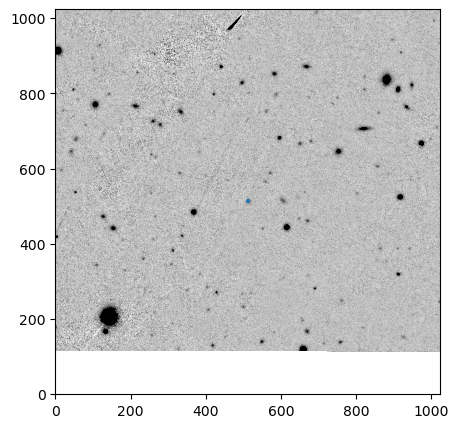

In [27]:
## see the image

fig = plt.figure(figsize=(5,5))

norm = simple_norm(sn_data, 'linear', percent=99)
plt.imshow(sn_data, norm=norm, origin='lower',cmap='Greys')
sn_x, sn_y = sn_wcs.all_world2pix(161.77716667, 0.01102778, 1)
plt.scatter(sn_x, sn_y, marker='+', s=10)

In [28]:
## define host galaxy detection threshold above the background
thres = 3
npix = 20
threshold = thres*sn_bkg.background_rms
segm_deblend = detect_sources(sn_data, threshold, npixels=npix)

# background error
err = calc_total_error(sn_data,sn_bkg.background_rms,sn_header['CELL.GAIN']*sn_header['EXPTIME'])
cat = SourceCatalog(sn_data,segm_deblend,error=err,kron_params=(2.5,1.4))
tbl = cat.to_table()

## pretty sure PS1 zeropoint is 27.5, you should check this
m_app = -2.5*np.log10(cat.kron_flux) + 27.5

## the equation from Edo's paper for r(?) band
sigma_m = (1/(0.33*np.log(10)))*10**(0.33*(m_app-24)-2.44)

## r50 is an array of half light radii for all detected objects in the frame
r50 = cat.fluxfrac_radius(0.5).value * 0.25

## r is an array of distance from the SN location to the centroid of each detected object
r = np.sqrt((tbl['xcentroid'].data-sn_x)**2+(tbl['ycentroid'].data-sn_y)**2)*0.25

## no uncertainties, so this is the effective radius for each object
R_e = np.sqrt(r**2+4*r50**2)

## probability of chance coincidence
P_cc = 1-np.exp(-np.pi*R_e**2*sigma_m)

## object with the lowest probability -- this is the "host"
host_p = np.nanmin(P_cc)

## get the properties of the host
host = cat.get_label(np.nanargmin(P_cc)+1)
host_tbl = host.to_table()
host_x, host_y = (host.xcentroid,host.ycentroid)

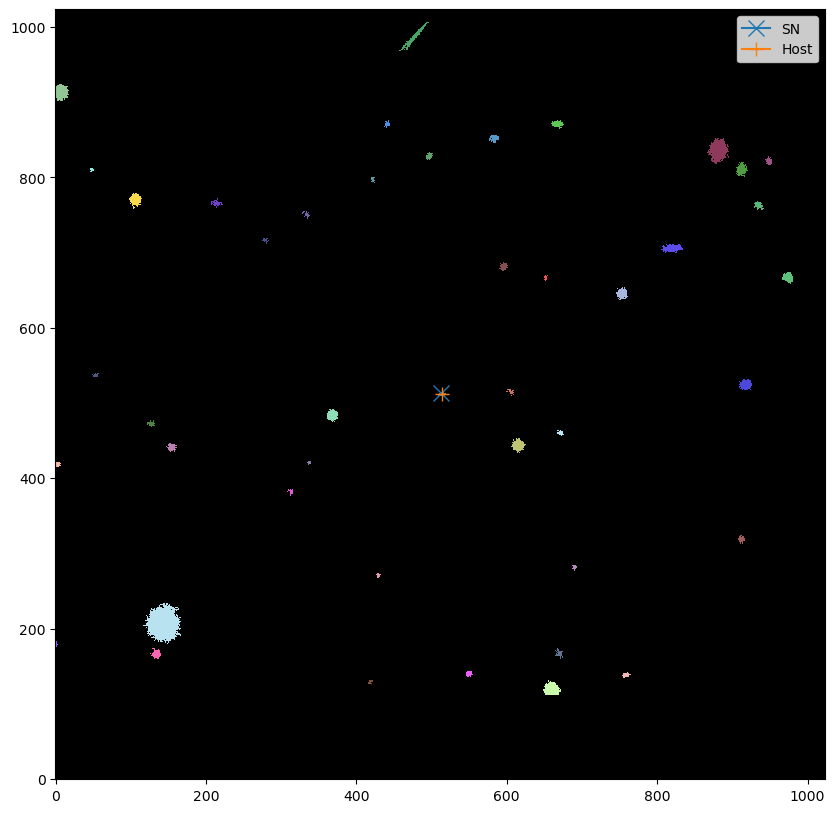

In [41]:
## plot it

fig, ax = plt.subplots(1,1,figsize=(10,10))
norm = simple_norm(segm_deblend, 'power', percent=99)
plt.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,interpolation='nearest')
plt.plot(sn_x, sn_y,marker='x',markersize=12, label='SN')
plt.plot(host_x, host_y,marker='+',markersize=10, label='Host')

## uncomment to zoom in
# plt.xlim(host_x-20,host_x+20)
# plt.ylim(host_y-20,host_y+20)
plt.legend()
plt.show()

In [42]:
print("{:.1f} s".format(time.time()-t0))

232.5 s
